In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!conda install -c chembl chembl_structure_pipeline
import chembl_structure_pipeline
from chembl_structure_pipeline import standardizer

In [ ]:
from IPython.display import clear_output

# https://www.dgl.ai/pages/start.html

# !pip install dgl
!pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html # FOR CUDA VERSION
!pip install dgllife
!pip install rdkit-pypi
!pip install --pre deepchem
!pip install ipython-autotime
!pip install gputil
!pip install psutil
!pip install humanize

%load_ext autotime

clear = clear_output()

time: 4.69 ms (started: 2021-11-30 12:22:05 +00:00)


In [ ]:
import os
from os import path
import statistics
import warnings
import random
import time 
import itertools
import psutil
import humanize
import GPUtil as GPU
import subprocess
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import tqdm
from tqdm import trange, tqdm_notebook, tnrange

import deepchem as dc
import rdkit
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize

import dgl
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv, SumPooling, MaxPooling
import dgl.function as fn
import dgllife
from dgllife import utils

# embedding
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.profiler import profile, record_function, ProfilerActivity
from torch.utils.tensorboard import SummaryWriter


import sklearn
from sklearn.metrics import (auc, roc_curve, roc_auc_score, average_precision_score, 
                             accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, 
                             f1_score, PrecisionRecallDisplay)
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore", message="DGLGraph.__len__")

DGLBACKEND = 'pytorch'

clear

def get_cmd_output(command):
  return subprocess.check_output(command,
                        stderr=subprocess.STDOUT,
                        shell=True).decode('UTF-8')

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


time: 8.99 s (started: 2021-11-30 12:22:05 +00:00)


## Create Dataset

In [ ]:
def create_dataset(df, name, bonds):
    print(f"Creating Dataset and Saving to {drive_path}/data/{name}.pkl")
    data = df.sample(frac=1)
    data = data.reset_index(drop=True)
    data['mol'] = data['smiles'].apply(lambda x: create_dgl_features(x, bonds))
    data.to_pickle(f"{drive_path}/data/{name}.pkl")
    return data

def featurize_atoms(mol):
  feats = []
  
  atom_features = utils.ConcatFeaturizer([
    utils.atom_type_one_hot,
    utils.atomic_number_one_hot,
    utils.atom_degree_one_hot,
    utils.atom_explicit_valence_one_hot,
    utils.atom_formal_charge_one_hot,
    utils.atom_num_radical_electrons_one_hot,
    utils.atom_hybridization_one_hot,
    utils.atom_is_aromatic_one_hot
  ])

  for atom in mol.GetAtoms():
    feats.append(atom_features(atom))
  return {'feats': torch.tensor(feats).float()}

def featurize_bonds(mol):
  feats = []
  
  bond_features = utils.ConcatFeaturizer([
    utils.bond_type_one_hot,
    utils.bond_is_conjugated_one_hot,
    utils.bond_is_in_ring_one_hot,
    utils.bond_stereo_one_hot,
    utils.bond_direction_one_hot,
  ])

  for bond in mol.GetBonds():
    feats.append(bond_features(bond))
    feats.append(bond_features(bond))
  return {'edge_feats': torch.tensor(feats).float()}

def create_dgl_features(smiles, bonds):
    mol = Chem.MolFromSmiles(smiles)
    mol = standardizer.standardize_mol(mol)
    
    if bonds:
        dgl_graph = utils.mol_to_bigraph(mol=mol,
                                    node_featurizer=featurize_atoms,
                                    edge_featurizer=featurize_bonds,
                                    canonical_atom_order=True)
    else:
      dgl_graph = utils.mol_to_bigraph(mol=mol,
                                    node_featurizer=featurize_atoms,
                                    canonical_atom_order=True)
    
    dgl_graph = dgl.add_self_loop(dgl_graph)
    
    return dgl_graph

def load_dataset(dataset, bonds=False, feat='graph', create_new=False):
  """
    dataset values: muv, tox21, dude-gpcr
    feat values: graph, ecfp
  """
  dataset_test_tasks = {
    'tox21': ['SR-HSE', 'SR-MMP', 'SR-p53'],
    'muv': ['MUV-832', 'MUV-846', 'MUV-852', 'MUV-858', 'MUV-859'],
    'dude-gpcr': ['adrb2', 'cxcr4']
  }

  dataset_original = dataset

  if bonds:
    dataset = dataset + "_with_bonds"

  if path.exists(f"{drive_path}/data/{dataset}_dgl.pkl") and not create_new:
    # Load Dataset
    print("Reading Pickle")
    if feat == 'graph':
      data = pd.read_pickle(f"{drive_path}/data/{dataset}_dgl.pkl")
    else:
      data = pd.read_pickle(f"{drive_path}/data/{dataset}_ecfp.pkl")
  else:
    # Create Dataset
    df = pd.read_csv(f"{drive_path}/data/raw/{dataset_original}.csv")
    if feat == 'graph':
      data = create_dataset(df, f"{dataset}_dgl", bonds)
    else:
      data = create_ecfp_dataset(df, f"{dataset}_ecfp")

  test_tasks = dataset_test_tasks.get(dataset_original)
  drop_cols = test_tasks.copy()
  drop_cols.extend(['mol_id', 'smiles', 'mol'])
  train_tasks = [x for x in list(data.columns) if x not in drop_cols]

  train_dfs = dict.fromkeys(train_tasks)
  for task in train_tasks:
      df = data[[task, 'mol']].dropna()
      df.columns = ['y', 'mol']
      # FOR BOND INFORMATION
      if with_bonds:
        for index, r in df.iterrows():
          if r.mol.edata['edge_feats'].shape[-1] < 17:
            df.drop(index, inplace=True)
      train_dfs[task] = df
  for key in train_dfs:
    print(key, len(train_dfs[key]))

  if feat == 'graph':
    feat_length = data.iloc[0].mol.ndata['feats'].shape[-1]
    print("Feature Length", feat_length)

    if with_bonds:
      feat_length = data.iloc[0].mol.edata['edge_feats'].shape[-1]
      print("Feature Length", feat_length)
    else:
      print("Edge Features: ", with_bonds)

  test_dfs = dict.fromkeys(test_tasks)

  for task in test_tasks:
      df = data[[task, 'mol']].dropna()
      df.columns = ['y', 'mol']

      # FOR BOND INFORMATION
      if with_bonds:
        for index, r in df.iterrows():
          if r.mol.edata['edge_feats'].shape[-1] < 17:
            df.drop(index, inplace=True)

      test_dfs[task] = df

  for key in test_dfs:
    print(key, len(test_dfs[key]))

  # return data, train_tasks, test_tasks
  return train_tasks, train_dfs, test_tasks, test_dfs

time: 154 ms (started: 2021-11-30 12:24:02 +00:00)


## Create Episode

In [ ]:
def create_episode(n_support_pos, n_support_neg, n_query, data, test=False, train_balanced=True):
  """
    n_query = per class data points
    Xy = dataframe dataset in format [['y', 'mol']]
  """
  support = []
  query = []

  n_query_pos = n_query
  n_query_neg = n_query

  support_neg = data[data['y'] == 0].sample(n_support_neg)
  support_pos = data[data['y'] == 1].sample(n_support_pos)

  # organise support by class in array dimensions
  support = np.array(support, dtype=object)
  support = np.append(support_neg, support_pos, axis=0)
  # support.append(support_neg.to_numpy())
  # support.append(support_pos.to_numpy())
  # support = np.array(support, dtype=object)
  # support_X = [rec[1] for sup_class in support for rec in sup_class]
  # support_y = np.asarray([rec[0] for sup_class in support for rec in sup_class], dtype=np.float16).flatten()

  data = data.drop(support_neg.index)
  data = data.drop(support_pos.index)

  if len(data[data['y'] == 1]) < n_query:
    n_query_pos = len(data[data['y'] == 1])

  if test:
    # test uses all data remaining
    query_neg = data[data['y'] == 0].sample(frac=1).to_numpy()
    query_pos = data[data['y'] == 1].sample(frac=1).to_numpy()
  elif (not test) and train_balanced:
    # for balanced queries, same size as support
    query_neg = data[data['y'] == 0].sample(n_query_neg).to_numpy()
    query_pos = data[data['y'] == 1].sample(n_query_pos).to_numpy()

  query = np.array(query, dtype=object)
  query = np.append(query_neg, query_pos, axis=0)

  # query_X = np.concatenate([query_neg[:, 1], query_pos[:, 1]])
  # query_y = np.concatenate([query_neg[:, 0], query_pos[:, 0]])
  
  # return support_X, support_y, query_X, query_y
  support = support.reshape(-1, support.shape[-1])
  # query = query.reshape(-1, query.shape[-1])

  all_combinations = list(itertools.product(support, query))

  combs = pd.DataFrame(all_combinations, columns=['support', 'query_set'])
  combs[['sup_y', 'sup_x']] = pd.DataFrame(combs.support.tolist())
  combs[['query_y', 'query_x']] = pd.DataFrame(combs.query_set.tolist())
  combs['target'] = np.where(((combs['sup_y'] == combs['query_y']) & (combs['sup_y'] == 1)), 1, 0)

  # conditions  = [ (combs['sup_y'] == combs['query_y']) & (combs['sup_y'] == 0), (combs['sup_y'] == combs['query_y']) & (combs['sup_y'] == 1), combs['sup_y'] != combs['query_y'] ]
  # choices     = [ 0, 1, 2 ]
  # combs["target"] = np.select(conditions, choices, default=np.nan)

  combs = combs.drop(columns=['support', 'query_set', 'sup_y', 'query_y'])
  combs_x = combs[['sup_x', 'query_x']].values.tolist()
  combs_y = combs.target.values.tolist()
             
  return combs_x, combs_y
  # return combs

time: 40.7 ms (started: 2021-11-30 12:22:15 +00:00)


In [ ]:
combs_x, combs_y = create_episode(1, 1, 3, train_dfs['NR-AR'], test=False, train_balanced=True)

combs_y

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

time: 21.9 ms (started: 2021-11-24 11:51:16 +00:00)


## Graph Embedding

In [ ]:
class SiameseGCNNet(nn.Module):
    def __init__(self, in_channels, out_channels=128):
      super(SiameseGCNNet, self).__init__()
      self.conv1 = GraphConv(in_channels, 64)
      self.conv2 = GraphConv(64, 128)
      self.conv3 = GraphConv(128, 64)
      self.sum_pool = SumPooling()
      self.dense = nn.Linear(64, out_channels)

      self.out = nn.Linear(out_channels, 1)

    def forward_one(self, graph, in_feat):
        h = self.conv1(graph, in_feat)
        h = F.relu(h)
        graph.ndata['h'] = h       
        graph.update_all(fn.copy_u('h', 'm'), fn.max('m', 'h'))
      
        h = self.conv2(graph, graph.ndata['h'])
        h = F.relu(h)
        graph.ndata['h'] = h
        graph.update_all(fn.copy_u('h', 'm'), fn.max('m', 'h'))

        h = self.conv3(graph, graph.ndata['h'])
        h = F.relu(h)
        graph.ndata['h'] = h
        graph.update_all(fn.copy_u('h', 'm'), fn.max('m', 'h'))

        output = self.sum_pool(graph, graph.ndata['h'])
        output = torch.tanh(output)
        output = self.dense(output)
        output = torch.tanh(output)
        return output

    def forward(self, x1, x1_feat, x2, x2_feat):
        out1 = self.forward_one(x1, x1_feat)
        out2 = self.forward_one(x2, x2_feat)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)
        #  return self.sigmoid(out)
        return out

time: 26.7 ms (started: 2021-11-30 12:22:15 +00:00)


## Training loop

In [ ]:
def train(train_tasks, train_dfs, balanced_queries, k_pos, k_neg, n_query, episodes, lr):
  writer = SummaryWriter()
  start_time = time.time()

  node_feat_size = 177
  embedding_size = 128
  siamese_net = SiameseGCNNet(node_feat_size, embedding_size)
  loss_fn = nn.BCEWithLogitsLoss()

  if torch.cuda.is_available(): 
    siamese_net = siamese_net.cuda()
    loss_fn = loss_fn.cuda()

  sn_optimizer = torch.optim.Adam(siamese_net.parameters(), lr = lr)
  sn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(sn_optimizer, patience=200, verbose=False)

  episode_num = 1
  early_stop = False
  losses = []

  running_loss = 0.0
  running_acc = 0.0
  running_roc = 0.0
  running_prc = 0.0

  # for task in shuffled_train_tasks:
  pbar = trange(episodes, desc=f"Training")
  # while episode_num < episodes and not early_stop:
  for episode in pbar:
    episode_loss = 0.0

    # SET TRAINING MODE
    siamese_net.train()

    # RANDOMISE ORDER OF TASKS PER EPISODE
    shuffled_train_tasks = random.sample(train_tasks, len(train_tasks))
    
    # LOOP OVER TASKS
    for task in shuffled_train_tasks:
      # CREATE EPISODE FOR TASK
      X = train_dfs[task]
      # X_support, y_support, X_query, y_query = create_episode(k_pos, k_neg, n_query, X, False, balanced_queries)
      episode_X, episode_y = create_episode(k_pos, k_neg, n_query, X, test=False, train_balanced=True)

      # TOTAL NUMBER OF QUERIES
      # total_query = int((y_query == 0).sum() + (y_query == 1).sum())

      # ONE HOT QUERY TARGETS
      targets = torch.FloatTensor(episode_y).to(torch.int64)
      # one_hot = F.one_hot(query_targets, num_classes=2)

      # query_targets = torch.FloatTensor(episode_y).to(torch.int64)
      # one_hot = torch.zeros(total_query, n_way)
      # one_hot[torch.arange(total_query), query_targets] = 1
      # one_hot = Variable(one_hot)

      if torch.cuda.is_available(): 
        targets=targets.cuda()

      # target_inds = torch.from_numpy(targets.astype('float32')).float()
      # target_inds = target_inds.unsqueeze(1).type(torch.int64)
      # targets = Variable(target_inds, requires_grad=False).to(device)
      
      # if torch.cuda.is_available(): 
      #   targets=targets.cuda()

      # n_support = k_pos + k_neg
      # flat_support = list(np.concatenate(X_support).flat)
      # X = flat_support + list(X_query)

      # CREATE EMBEDDINGS
      dataloader = GraphDataLoader(episode_X, batch_size=(len(episode_X)), shuffle=False, pin_memory=True)
      for graph1, graph2 in dataloader:
        graph1 = graph1.to(device)
        graph2 = graph2.to(device)
  
        if with_bonds:
          logits = siamese_net.forward(graph, (graph.ndata['feats'].float(), graph.edata['edge_feats'].float())) # FOR NODES + EDGES ONLY
        else:
          logits = siamese_net.forward(graph1, graph1.ndata['feats'].float(), graph2, graph2.ndata['feats'].float()) # FOR NODES ONLY
      
      loss = loss_fn(logits, targets.unsqueeze(1).float())

      siamese_net.zero_grad()
      loss.backward()
      sn_optimizer.step()

      logits = nn.Sigmoid()(logits)
      logits = logits.detach().cpu()
      y_hat_actual = np.round(logits)
      y_hat = logits

      targets = targets.squeeze().cpu()
      y_hat = y_hat.squeeze().detach().cpu()
      
      roc = roc_auc_score(targets, y_hat)
      prc = average_precision_score(targets, y_hat)
      acc = accuracy_score(targets, y_hat_actual)

      # EVALUATE TRAINING LOOP ON TASK
      episode_loss += loss.item()
      running_loss += loss.item()
      running_acc += acc
      running_roc += roc
      running_prc += prc

    pbar.set_description(f"Episode {episode_num} - Loss {loss.item():.6f} - Acc {acc:.4f} - LR {sn_optimizer.param_groups[0]['lr']}")
    pbar.refresh()

    losses.append(episode_loss / len(train_tasks))
    writer.add_scalar('Loss/train', episode_loss / len(train_tasks), episode_num)

    if sn_optimizer.param_groups[0]['lr'] < 0.000001:
      break # EARLY STOP
    elif episode_num < episodes:
      episode_num += 1

    sn_scheduler.step(loss)

  epoch_loss = running_loss / (episode_num*len(train_tasks))
  epoch_acc = running_acc / (episode_num*len(train_tasks))
  epoch_roc = running_roc / (episode_num*len(train_tasks))
  epoch_prc = running_prc / (episode_num*len(train_tasks))

  print(f'Loss: {epoch_loss:.5f} Acc: {epoch_acc:.4f} ROC: {epoch_roc:.4f} PRC: {epoch_prc:.4f}')

  end_time = time.time()
  train_info = {
      "losses": losses,
      "duration": str(timedelta(seconds=(end_time - start_time))),
      "episodes": episode_num,
      "train_roc": epoch_roc,
      "train_prc": epoch_prc
  }

  return siamese_net, train_info

time: 139 ms (started: 2021-11-30 12:22:15 +00:00)


## Testing Loop

In [ ]:
def test(siamese_net, test_tasks, test_dfs, k_pos, k_neg, rounds):
  siamese_net.eval()

  test_info = {}

  with torch.no_grad():
    for task in test_tasks:

      Xy = test_dfs[task]

      running_loss = []
      running_acc = []
      running_roc = [0]
      running_prc = [0]

      running_preds = []
      running_targets = []
      running_actuals = []

      for round in trange(rounds):
        episode_X, episode_y = create_episode(k_pos, k_neg, n_query=0, data=Xy, test=True, train_balanced=False)

        targets = torch.FloatTensor(episode_y).to(torch.int64)

        if torch.cuda.is_available(): 
          targets=targets.cuda()

        # CREATE EMBEDDINGS
        logits_total = torch.tensor([])
        logits_total = logits_total.cuda()

        dataloader = GraphDataLoader(episode_X, batch_size=1000, shuffle=False, pin_memory=True)
        for graph1, graph2 in dataloader:
          graph1 = graph1.to(device)
          graph2 = graph2.to(device)
    
          if with_bonds:
            logits = siamese_net.forward(graph, (graph.ndata['feats'].float(), graph.edata['edge_feats'].float())) # FOR NODES + EDGES ONLY
          else:
            logits = siamese_net.forward(graph1, graph1.ndata['feats'].float(), graph2, graph2.ndata['feats'].float()) # FOR NODES ONLY

          logits = nn.Sigmoid()(logits)
          logits_total = torch.cat((logits_total, logits), 0)

        # y_hat = np.round(logits.detach().cpu())
        logits_total = logits_total.detach().cpu()
        y_hat_actual = np.round(logits_total)
        y_hat = logits_total

        targets = targets.squeeze().cpu()
        y_hat = y_hat.squeeze().detach().cpu()

        roc = roc_auc_score(targets, y_hat)
        prc = average_precision_score(targets, y_hat)
        # acc = accuracy_score(targets, y_hat)

        running_preds.append(y_hat)
        running_actuals.append(y_hat_actual)
        running_targets.append(targets)

        # running_acc.append(acc)
        running_roc.append(roc)
        running_prc.append(prc)

      median_index = running_roc.index(statistics.median(running_roc))
      if median_index == rounds:
        median_index = median_index - 1
      chart_preds = running_preds[median_index]
      chart_actuals = running_actuals[median_index].detach().cpu()
      chart_targets = running_targets[median_index]

      c_auc = roc_auc_score(chart_targets, chart_preds)
      c_fpr, c_tpr, _ = roc_curve(chart_targets, chart_preds)
      plt.plot(c_fpr, c_tpr, marker='.', label = 'AUC = %0.2f' % c_auc)
      plt.plot([0, 1], [0, 1],'r--', label='No Skill')
      # plt.plot([0, 0, 1], [0, 1, 1], 'g--', label='Perfect Classifier')
      plt.title('Receiver Operating Characteristic')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.legend(loc = 'best')
      plt.savefig(f"{drive_path}/{method_dir}/graphs/roc_{dataset}_{task}_pos{n_pos}_neg{n_neg}.png")
      plt.figure().clear()

      # prc_graph = PrecisionRecallDisplay.from_predictions(chart_targets, chart_preds)
      c_precision, c_recall, _ = precision_recall_curve(chart_targets, chart_preds)
      plt.title('Precision Recall Curve')
      # plt.plot([0, 1], [0, 0], 'r--', label='No Skill')
      no_skill = len(chart_targets[chart_targets==1]) / len(chart_targets)
      plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
      # plt.plot([0, 1, 1], [1, 1, 0], 'g--', label='Perfect Classifier')
      plt.plot(c_recall, c_precision, marker='.', label = 'AUC = %0.2f' % auc(c_recall, c_precision))
      plt.xlabel('Recall')
      plt.ylabel('Precision')
      plt.legend(loc = 'best')
      plt.savefig(f"{drive_path}/{method_dir}/graphs/prc_{dataset}_{task}_pos{n_pos}_neg{n_neg}.png")
      plt.figure().clear()

      cm = ConfusionMatrixDisplay.from_predictions(chart_targets, chart_actuals)
      plt.title('Confusion Matrix')
      plt.savefig(f"{drive_path}/{method_dir}/graphs/cm_{dataset}_{task}_pos{n_pos}_neg{n_neg}.png")
      plt.figure().clear()

      running_roc.pop(0) # remove the added 0
      running_prc.pop(0) # remove the added 0 
      # round_acc = f"{statistics.mean(running_acc):.3f} \u00B1 {statistics.stdev(running_acc):.3f}"
      round_roc = f"{statistics.mean(running_roc):.3f} \u00B1 {statistics.stdev(running_roc):.3f}"
      round_prc = f"{statistics.mean(running_prc):.3f} \u00B1 {statistics.stdev(running_prc):.3f}"

      test_info[task] = {
          # "acc": round_acc,
          "roc": round_roc,
          "prc": round_prc,
          "roc_values": running_roc,
          "prc_values": running_prc
      }

      print(f'Test {task}')
      # print(f"Acc: {round_acc}")
      print(f"ROC: {round_roc}")
      print(f"PRC: {round_prc}")

    return targets, y_hat, test_info

time: 149 ms (started: 2021-11-30 12:22:15 +00:00)


## Initiate Training and Testing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 20.6 s (started: 2021-11-30 12:22:15 +00:00)


In [ ]:
# PATHS
drive_path = "/content/drive/MyDrive/Colab Notebooks/MSC_21"
method_dir = "SiameseNets"
log_path = f"{drive_path}/{method_dir}/logs/"

# PARAMETERS
dataset = 'dude-gpcr'
with_bonds = False 
test_rounds = 20
n_query = 64 # per class
episodes = 10000
lr = 0.001
balanced_queries = True

time: 5.06 ms (started: 2021-11-30 12:22:36 +00:00)


In [ ]:
#FOR DETERMINISTIC REPRODUCABILITY
randomseed = 12
torch.manual_seed(randomseed) 
np.random.seed(randomseed)
random.seed(randomseed)
torch.cuda.manual_seed(randomseed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.is_available()
torch.backends.cudnn.benchmark = False # selects fastest conv algo
torch.backends.cudnn.deterministic = True

# LOAD DATASET
# data, train_tasks, test_tasks = load_dataset(dataset, bonds=with_bonds, create_new=False)
train_tasks, train_dfs, test_tasks, test_dfs = load_dataset(dataset, bonds=with_bonds, feat='graph', create_new=False)
# print(dataset)

# train_dfs = dict.fromkeys(train_tasks)
# for task in train_tasks:
#     df = data[[task, 'mol']].dropna()
#     df.columns = ['y', 'mol']
#     # FOR BOND INFORMATION
#     if with_bonds:
#       for index, r in df.iterrows():
#         if r.mol.edata['edge_feats'].shape[-1] < 17:
#           df.drop(index, inplace=True)
#     train_dfs[task] = df
# for key in train_dfs:
#   print(key, len(train_dfs[key]))

# feat_length = data.iloc[0].mol.ndata['feats'].shape[-1]
# print("Feature Length", feat_length)

# if with_bonds:
#   feat_length = data.iloc[0].mol.edata['edge_feats'].shape[-1]
#   print("Feature Length", feat_length)
# else:
#   print("Edge Features: ", with_bonds)

# test_dfs = dict.fromkeys(test_tasks)

# for task in test_tasks:
#     df = data[[task, 'mol']].dropna()
#     df.columns = ['y', 'mol']

#     # FOR BOND INFORMATION
#     if with_bonds:
#       for index, r in df.iterrows():
#         if r.mol.edata['edge_feats'].shape[-1] < 17:
#           df.drop(index, inplace=True)

#     test_dfs[task] = df

# for key in test_dfs:
#   print(key, len(test_dfs[key]))

Reading Pickle
aa2ar 32032
drd3 34530
adrb1 16097
Feature Length 177
Edge Features:  False
adrb2 15231
cxcr4 3446
time: 41.1 s (started: 2021-11-30 12:24:33 +00:00)



RUNNING 10+/10-


Episode 2756 - Loss 0.001375 - Acc 1.0000 - LR 1.0000000000000002e-07:  28%|██▊       | 2755/10000 [26:30<1:09:41,  1.73it/s]


Loss: 0.04288 Acc: 0.9840 ROC: 0.9947 PRC: 0.9853


100%|██████████| 20/20 [07:52<00:00, 23.63s/it]


Test adrb2
ROC: 0.998 ± 0.000
PRC: 0.963 ± 0.014


100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


Test cxcr4
ROC: 0.570 ± 0.028
PRC: 0.014 ± 0.002

RUNNING 5+/10-


Episode 2883 - Loss 0.011981 - Acc 0.9974 - LR 1.0000000000000002e-07:  29%|██▉       | 2882/10000 [21:12<52:23,  2.26it/s]


Loss: 0.04298 Acc: 0.9838 ROC: 0.9928 PRC: 0.9744


100%|██████████| 20/20 [05:56<00:00, 17.83s/it]


Test adrb2
ROC: 0.998 ± 0.005
PRC: 0.959 ± 0.047


100%|██████████| 20/20 [01:17<00:00,  3.86s/it]


Test cxcr4
ROC: 0.525 ± 0.038
PRC: 0.031 ± 0.012

RUNNING 1+/10-


Episode 2055 - Loss 0.009172 - Acc 0.9986 - LR 1.0000000000000002e-07:  21%|██        | 2054/10000 [12:13<47:17,  2.80it/s]


Loss: 0.05394 Acc: 0.9815 ROC: 0.9755 PRC: 0.8572


100%|██████████| 20/20 [04:19<00:00, 12.98s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

Test adrb2
ROC: 0.998 ± 0.001
PRC: 0.909 ± 0.117


100%|██████████| 20/20 [00:55<00:00,  2.78s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

Test cxcr4
ROC: 0.520 ± 0.087
PRC: 0.039 ± 0.066

RUNNING 1+/5-


Episode 2832 - Loss 0.009930 - Acc 0.9987 - LR 1.0000000000000002e-07:  28%|██▊       | 2831/10000 [11:36<29:24,  4.06it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Loss: 0.06678 Acc: 0.9746 ROC: 0.9810 PRC: 0.9097


100%|██████████| 20/20 [02:18<00:00,  6.94s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

Test adrb2
ROC: 0.998 ± 0.000
PRC: 0.913 ± 0.131


100%|██████████| 20/20 [00:30<00:00,  1.54s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

Test cxcr4
ROC: 0.520 ± 0.084
PRC: 0.050 ± 0.082

RUNNING 1+/1-


Episode 2955 - Loss 0.014790 - Acc 1.0000 - LR 1.0000000000000002e-07:  30%|██▉       | 2954/10000 [08:19<19:51,  5.91it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Loss: 0.14592 Acc: 0.9406 ROC: 0.9728 PRC: 0.9353


100%|██████████| 20/20 [00:47<00:00,  2.36s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

Test adrb2
ROC: 0.998 ± 0.001
PRC: 0.909 ± 0.052


100%|██████████| 20/20 [00:11<00:00,  1.76it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

Test cxcr4
ROC: 0.545 ± 0.040
PRC: 0.091 ± 0.102


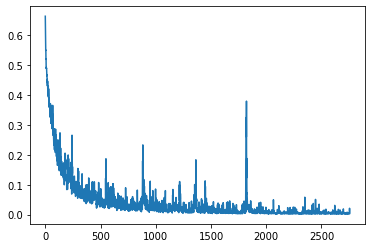

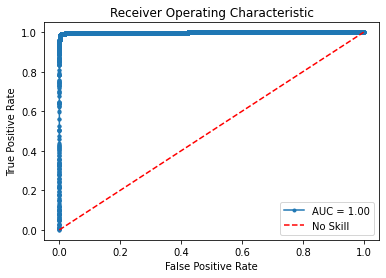

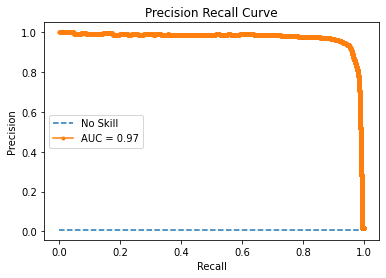

<Figure size 432x288 with 0 Axes>

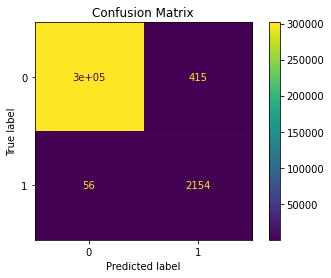

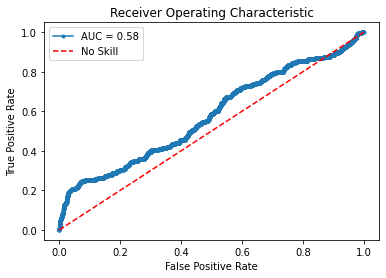

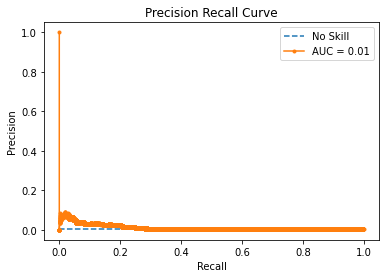

<Figure size 432x288 with 0 Axes>

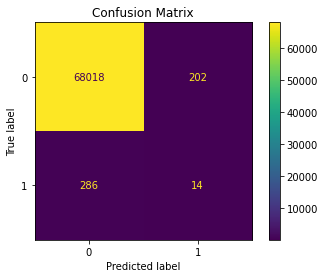

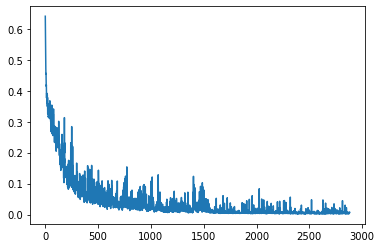

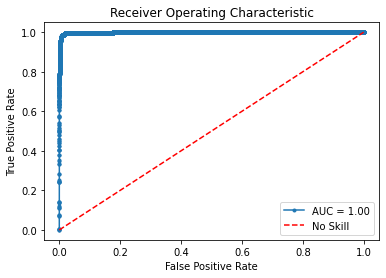

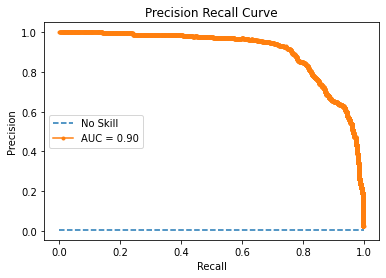

<Figure size 432x288 with 0 Axes>

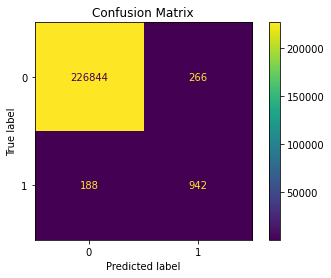

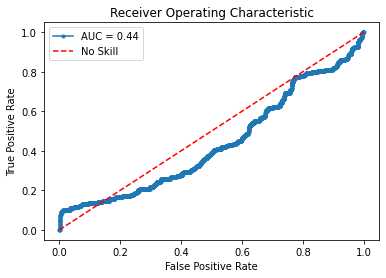

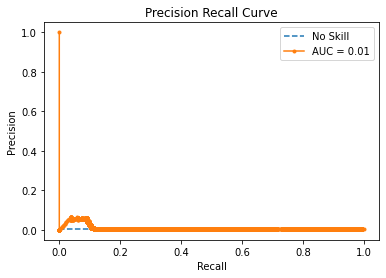

<Figure size 432x288 with 0 Axes>

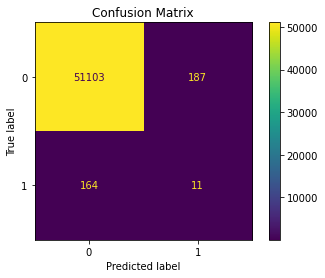

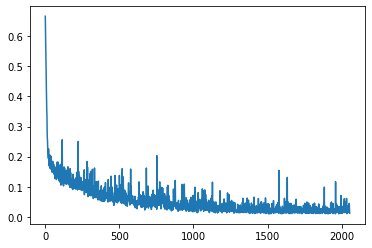

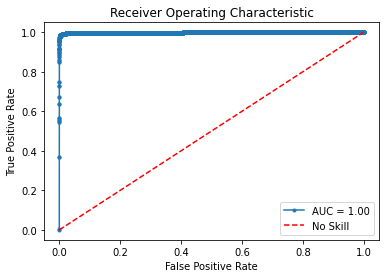

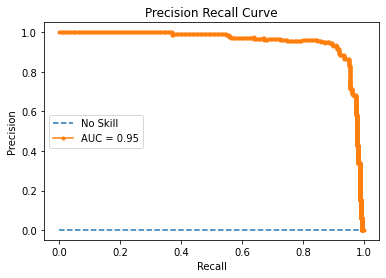

<Figure size 432x288 with 0 Axes>

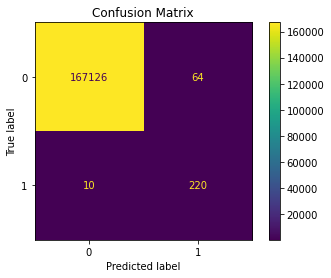

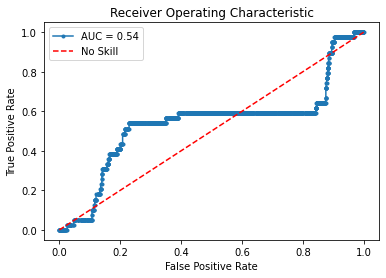

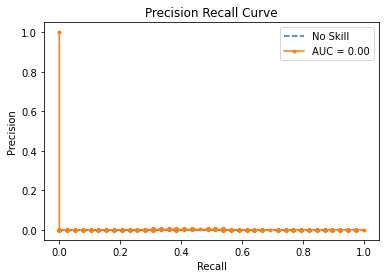

<Figure size 432x288 with 0 Axes>

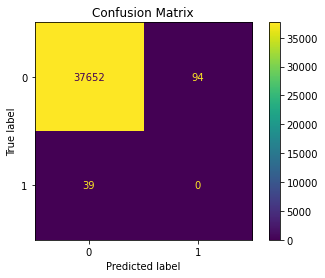

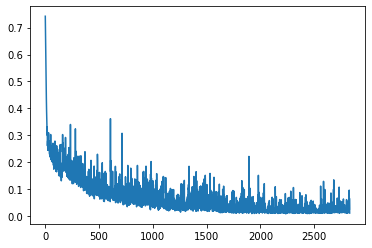

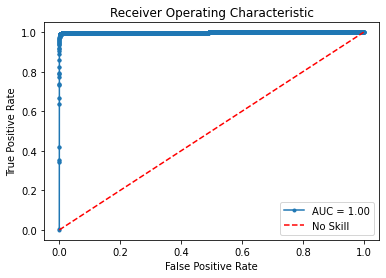

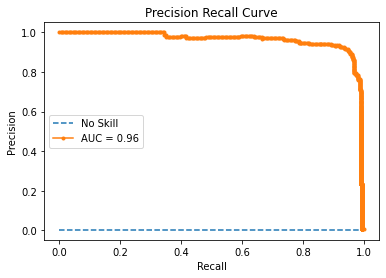

<Figure size 432x288 with 0 Axes>

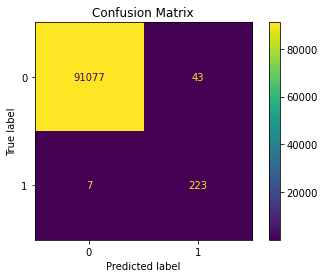

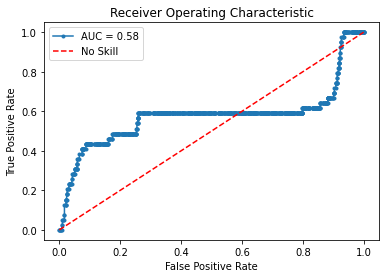

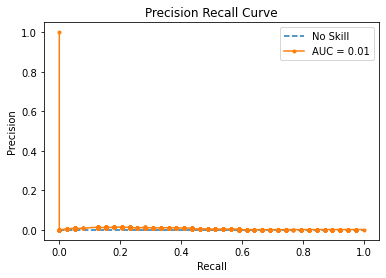

<Figure size 432x288 with 0 Axes>

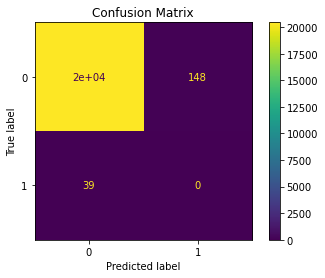

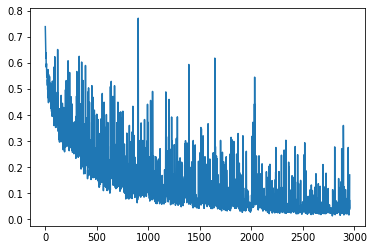

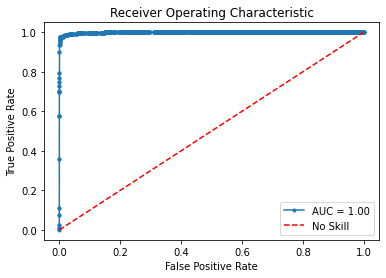

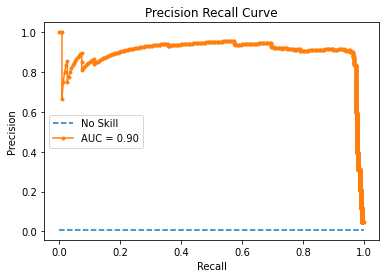

<Figure size 432x288 with 0 Axes>

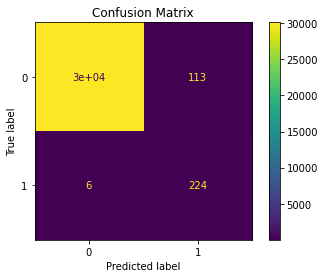

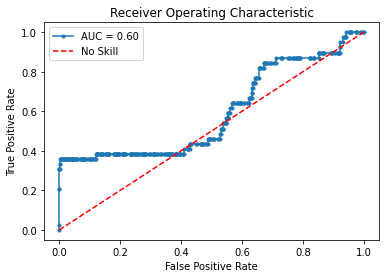

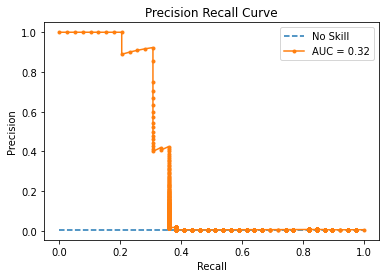

<Figure size 432x288 with 0 Axes>

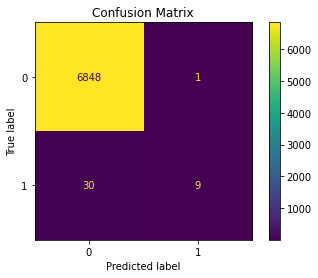

<Figure size 432x288 with 0 Axes>

time: 1h 46min 11s (started: 2021-11-30 12:26:14 +00:00)


In [ ]:
combinations = [
    [10, 10],
    [5, 10], 
    [1, 10], 
    [1, 5], 
    [1, 1]
]

cols = [
  'DATE', 'CPU', 'CPU COUNT',	'GPU', 'GPU RAM',	'RAM',	'CUDA',	
  'REF', 'DATASET', 'ARCHITECTURE',	
  'SPLIT',	'TARGET',	'ACCURACY',	'ROC',	'PRC',
  'ROC_VALUES', 'PRC_VALUES',
  'TRAIN ROC',	'TRAIN PRC',	'EPISODES',	'TRAINING TIME'
]

load_from_saved = False

for comb in combinations:
  n_pos = comb[0]
  n_neg = comb[1]
  results = pd.DataFrame(columns=cols)
  print(f"\nRUNNING {n_pos}+/{n_neg}-")

  if load_from_saved:
    siamese_net = SiameseGCNNet(177, 128)
    siamese_net.load_state_dict(torch.load(f"{drive_path}/{method_dir}/{dataset}_encoder_pos{n_pos}_neg{n_neg}.pt"))
    siamese_net.to(device)
  else:
    siamese_net, train_info = train(train_tasks, train_dfs, balanced_queries, n_pos, n_neg, n_query, episodes, lr)

    if with_bonds:
      torch.save(siamese_net.state_dict(), f"{drive_path}/{method_dir}/{dataset}_encoder_pos{n_pos}_neg{n_neg}_bonds.pt")
    else:
      torch.save(siamese_net.state_dict(), f"{drive_path}/{method_dir}/{dataset}_encoder_pos{n_pos}_neg{n_neg}.pt")
    
    loss_plot = plt.plot(train_info['losses'])[0]
    loss_plot.figure.savefig(f"{drive_path}/{method_dir}/loss_plots/{dataset}_pos{n_pos}_neg{n_neg}.png")
    plt.figure().clear()

  targets, preds, test_info = test(siamese_net, test_tasks, test_dfs, n_pos, n_neg, test_rounds)

  dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
  cpu = get_cmd_output('cat /proc/cpuinfo | grep -E "model name"')
  cpu = cpu.split('\n')[0].split('\t: ')[-1]
  cpu_count = psutil.cpu_count()
  cuda_version = get_cmd_output('nvcc --version | grep -E "Build"')
  gpu = get_cmd_output("nvidia-smi -L")
  general_ram_gb = humanize.naturalsize(psutil.virtual_memory().available)
  gpu_ram_total_mb = GPU.getGPUs()[0].memoryTotal


  for target in test_info:
    if load_from_saved:
      rec = pd.DataFrame([[dt_string, cpu, cpu_count, gpu, gpu_ram_total_mb, general_ram_gb, cuda_version, "MSC", 
                          dataset, {method_dir}, f"{n_pos}+/{n_neg}-", target, 0, test_info[target]['roc'], test_info[target]['prc'], 
                           test_info[target]['roc_values'], test_info[target]['prc_values'],
                          99, 99, 99, 102]], columns=cols)
  
      results = pd.concat([results, rec])
    else:
      rec = pd.DataFrame([[dt_string, cpu, cpu_count, gpu, gpu_ram_total_mb, general_ram_gb, cuda_version, "MSC", 
                          dataset, {method_dir}, f"{n_pos}+/{n_neg}-", target, 0, test_info[target]['roc'], test_info[target]['prc'],
                           test_info[target]['roc_values'], test_info[target]['prc_values'], 
                          train_info["train_roc"], train_info["train_prc"], train_info["episodes"], train_info["duration"]
            ]], columns=cols)
  
      results = pd.concat([results, rec])

  if load_from_saved:
    results.to_csv(f"{drive_path}/results/{dataset}_{method_dir}_pos{n_pos}_neg{n_neg}_from_saved.csv", index=False)
  else:
    results.to_csv(f"{drive_path}/results/{dataset}_{method_dir}_pos{n_pos}_neg{n_neg}.csv", index=False)